In [15]:
import iris
import cv2
import matplotlib.pyplot as plt

print(iris.__version__)


subject1_first_image = cv2.imread("./example_orb_image_1.png", cv2.IMREAD_GRAYSCALE)
subject1_second_image = cv2.imread("./example_orb_image_2.png", cv2.IMREAD_GRAYSCALE)
subject2_first_image = cv2.imread("./example_orb_image_3.png", cv2.IMREAD_GRAYSCALE)
iris_pipeline = iris.IRISPipeline()

output_1 = iris_pipeline(subject1_first_image, eye_side="left")
subject1_first_code = output_1['iris_template']

output_2 = iris_pipeline(subject1_second_image, eye_side="left")
subject1_second_code = output_2['iris_template']

output_3 = iris_pipeline(subject2_first_image, eye_side="left")
subject2_first_code = output_3['iris_template']

1.8.2


0.22724899947798852
0.4514372433494019
0.4499949844518006
Predictions: [1, 0, 0]
Ground truth: [1, 0, 0]
Confusion Matrix:
 [[2 0]
 [0 1]]


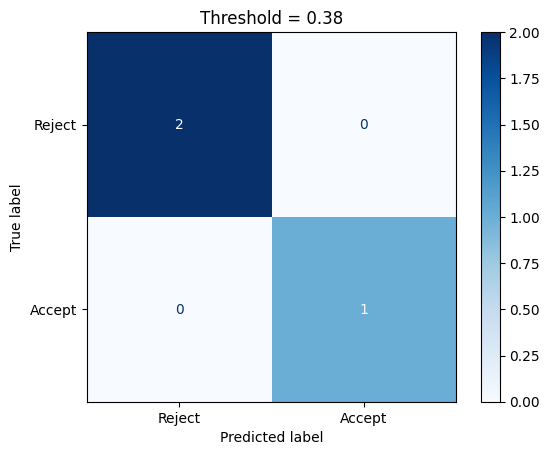

In [16]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Your threshold (you can tune this later)
threshold = 0.38

# All subject templates and masks
templates = [
    np.array(subject1_first_code.iris_codes),
    np.array(subject1_second_code.iris_codes),
    np.array(subject2_first_code.iris_codes)
]

masks = [
    np.array(subject1_first_code.mask_codes),
    np.array(subject1_second_code.mask_codes),
    np.array(subject2_first_code.mask_codes)
]

# Ground truth for the 3 possible pairs
# Compare subject1 vs subject2 → same person → 1
# Compare subject1 vs subject3 → different → 0
# Compare subject2 vs subject3 → different → 0
ground_truth = [1, 0, 0]
predicted = []

# All unique index pairs (no self-comparison)
index_pairs = [(0,1), (0,2), (1,2)]

for i, j in index_pairs:
    template1 = templates[i]
    mask1 = masks[i]
    template2 = templates[j]
    mask2 = masks[j]

    min_distance = 1.0
    best_shift = 0

    for shift in range(-7, 8):
        t2_shifted = np.roll(template2, shift=shift, axis=2)
        m2_shifted = np.roll(mask2, shift=shift, axis=2)

        xor_real = template1[..., 0] ^ t2_shifted[..., 0]
        xor_imag = template1[..., 1] ^ t2_shifted[..., 1]

        valid_mask_real = mask1[..., 0] & m2_shifted[..., 0]
        valid_mask_imag = mask1[..., 1] & m2_shifted[..., 1]

        masked_xor_real = xor_real & valid_mask_real
        masked_xor_imag = xor_imag & valid_mask_imag

        num_diff = np.sum(masked_xor_real) + np.sum(masked_xor_imag)
        num_valid = np.sum(valid_mask_real) + np.sum(valid_mask_imag)

        if num_valid == 0:
            distance = 1.0
        else:
            distance = num_diff / num_valid

        if distance < min_distance:
            min_distance = distance
            best_shift = -shift
            
    print(min_distance)

    # Decide based on threshold
    decision = 1 if min_distance < threshold else 0
    predicted.append(decision)

# Show results
print("Predictions:", predicted)
print("Ground truth:", ground_truth)

# Confusion matrix
cm = confusion_matrix(ground_truth, predicted)
print("Confusion Matrix:\n", cm)

# Optional: visualize
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Reject", "Accept"])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Threshold = {threshold}")
plt.show()
